In [500]:
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from cassandra.cluster import Cluster
from functools import reduce

from pyspark import Row
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import substring
import geopandas as geo # install
import joypy# install
import seaborn as sns

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.11:2.4.2'

# CO Emission in- or decrease throughout Sars-Covid-19
## Introduction
Am 1. Dezember 2019 wurde der erste Sars-Covid 19 Fall registriert, ein Thema das wohl niemanden entgangen ist mit über 200 betroffenen Ländern. Am 11. März wurde COVID dann zu einer Pandemie erklärt.

Auch Österreich war unter den betroffenen Ländern mit über 5 Milionen fällen bis heute(Okt. 2022).
Für viele bedeuteten die Landesweit verordneten Lockdowns Home office, doch einige, etwa die Fabriken, konnten nur begrentzt von zu Hause aus gesteurt werden. Dies hatte zu folge das einige Fabriken über den Zeitraum den Lockdowns herunterfahren mussten und vermeindliche Emissionen reduziert wurden.

Unter den vermeindlichen Emissionen befindet sich auch das CO, ein unvollständiges CO2 Gas welches bei unvollständigen Verbrennungen entstehen kann.
Grundsätzlich gilt es als toxisch und aufgrund von geruchs und geschmacksneutralität ist es auch schwer zu erkennen. Durch seine instabile struktur verbindet sich das CO entweder schnell zu einem vollständigen CO2 oder zerfällt zu einem anderen Element.

# Data Source


### CO API
Get JSON date from the API

### Get Countries of Regions (for example all countries of Europe)
Search by continent (region): Africa, Americas, Asia, Europe, Oceania

In [142]:
country_api = "https://restcountries.com/v3.1/region/"
region = "europe"
country_api_path = country_api + region

country_data = requests.get(country_api_path).text
country_data_json = json.loads(country_data)
country_data_json[0]

{'name': {'common': 'Hungary',
  'official': 'Hungary',
  'nativeName': {'hun': {'official': 'Magyarország',
    'common': 'Magyarország'}}},
 'tld': ['.hu'],
 'cca2': 'HU',
 'ccn3': '348',
 'cca3': 'HUN',
 'cioc': 'HUN',
 'independent': True,
 'status': 'officially-assigned',
 'unMember': True,
 'currencies': {'HUF': {'name': 'Hungarian forint', 'symbol': 'Ft'}},
 'idd': {'root': '+3', 'suffixes': ['6']},
 'capital': ['Budapest'],
 'altSpellings': ['HU'],
 'region': 'Europe',
 'subregion': 'Central Europe',
 'languages': {'hun': 'Hungarian'},
 'translations': {'ara': {'official': 'الجمهورية المجرية', 'common': 'المجر'},
  'bre': {'official': 'Hungaria', 'common': 'Hungaria'},
  'ces': {'official': 'Maďarsko', 'common': 'Maďarsko'},
  'cym': {'official': 'Hungary', 'common': 'Hungary'},
  'deu': {'official': 'Ungarn', 'common': 'Ungarn'},
  'est': {'official': 'Ungari', 'common': 'Ungari'},
  'fin': {'official': 'Unkari', 'common': 'Unkari'},
  'fra': {'official': 'Hongrie', 'common': 

Get all the ISO 3166-1 alpha-2 (cca2) code from the countries in a list

In [143]:
country_eu_cca2 = []
for country in country_data_json:
    country_eu_cca2.append(country["cca2"])

Now get all the supported countries of the Covid-19 API

In [144]:
country_covid_api = "https://api.covid19api.com/countries"
supp_country_covid_data = requests.get(country_covid_api).text
supp_country_covid_data_json = json.loads(supp_country_covid_data)
supp_country_covid_data_json[0]

{'Country': 'Israel', 'Slug': 'israel', 'ISO2': 'IL'}

Get all supported countries of the CO API

In [145]:
country_co_api = "https://api.v2.emissions-api.org/api/v2/countries.json"
supp_country_co_data = requests.get(country_co_api).text
supp_country_co_data_json = json.loads(supp_country_co_data)
supp_country_co_data_json

{'AE': 'United Arab Emirates',
 'AF': 'Afghanistan',
 'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'AL': 'Albania',
 'ALB': 'Albania',
 'AM': 'Armenia',
 'AO': 'Angola',
 'AQ': 'Antarctica',
 'AR': 'Argentina',
 'ARE': 'United Arab Emirates',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'AT': 'Austria',
 'ATA': 'Antarctica',
 'ATF': 'Fr. S. Antarctic Lands',
 'AU': 'Australia',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZ': 'Azerbaijan',
 'AZE': 'Azerbaijan',
 'BA': 'Bosnia and Herz.',
 'BD': 'Bangladesh',
 'BDI': 'Burundi',
 'BE': 'Belgium',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BF': 'Burkina Faso',
 'BFA': 'Burkina Faso',
 'BG': 'Bulgaria',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHS': 'Bahamas',
 'BI': 'Burundi',
 'BIH': 'Bosnia and Herz.',
 'BJ': 'Benin',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BN': 'Brunei',
 'BO': 'Bolivia',
 'BOL': 'Bolivia',
 'BR': 'Brazil',
 'BRA': 'Brazil',
 'BRN': 'Brunei',
 'BS': 'Bahamas',
 'BT': 'Bhutan',
 'BTN': 'Bhutan',
 'BW': 'Botswana',
 'BWA': 'Botswana'

Get all the ISO 3166-1 alpha-2 (cca2) code from the countries in a list

In [146]:
supp_country_covid_eu_cca2 = {}
for country in supp_country_covid_data_json:
    supp_country_covid_eu_cca2[country["ISO2"]] = country["Country"]

Check if our Covid-19 API and our CO API supported all these countries from europe region

In [147]:
is_valid_country = {}
for country in country_eu_cca2:
    if country in supp_country_covid_eu_cca2:
        if country in supp_country_co_data_json:
            is_valid_country[country] = supp_country_covid_eu_cca2[country]

In [189]:
len(is_valid_country)

40

In [222]:
co_data_json = []
for country in is_valid_country:
    co_api = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/average.json?country="
    co_api_path = "&begin=2020-01-01&end=2021-01-01"
    co_data = requests.get(co_api + country + co_api_path).text
    for data in json.loads(co_data):
        data.update({"Country": is_valid_country[country]})
        co_data_json.append(data)

Take a look at 01.01.2020 - 01.01.2021

### Covid-19 API
Get JSON data from the API

In [209]:
covid_data_json = []
for country in is_valid_country:
    covid_api = "https://api.covid19api.com/country/"
    covid_api_path = "/status/confirmed?from=2020-01-01T00:00:00Z&to=2021-01-01T00:00:00Z"

    covid_data = requests.get(covid_api + country + covid_api_path).text
    for data in json.loads(covid_data):
        covid_data_json.append(data)

In [220]:
covid_data_json

[{'Country': 'Hungary',
  'CountryCode': 'HU',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.16',
  'Lon': '19.5',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-22T00:00:00Z'},
 {'Country': 'Hungary',
  'CountryCode': 'HU',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.16',
  'Lon': '19.5',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-23T00:00:00Z'},
 {'Country': 'Hungary',
  'CountryCode': 'HU',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.16',
  'Lon': '19.5',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-24T00:00:00Z'},
 {'Country': 'Hungary',
  'CountryCode': 'HU',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.16',
  'Lon': '19.5',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-25T00:00:00Z'},
 {'Country': 'Hungary',
  'CountryCode': 'HU',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.16',
  'Lon': '19.5',
  'Cases': 0,
  'Status': 'confirmed',
  'Da

Load data into Spark-dataframe for data quality checking

In [152]:
# instantiate a Spark session
spark = SparkSession.builder.master("local[4]").appName("BigData-Covid-CO").getOrCreate()
spark

In [227]:
covid_df = spark.createDataFrame(covid_data_json)
co_df = spark.createDataFrame(co_data_json)

In [213]:
covid_df.schema

StructType([StructField('Cases', LongType(), True), StructField('City', StringType(), True), StructField('CityCode', StringType(), True), StructField('Country', StringType(), True), StructField('CountryCode', StringType(), True), StructField('Date', StringType(), True), StructField('Lat', StringType(), True), StructField('Lon', StringType(), True), StructField('Province', StringType(), True), StructField('Status', StringType(), True)])

In [214]:
co_df.schema

StructType([StructField('Country', StringType(), True), StructField('average', DoubleType(), True), StructField('end', StringType(), True), StructField('start', StringType(), True)])

In [228]:
co_df.show(5)

+-------+--------------------+--------------------+--------------------+
|Country|             average|                 end|               start|
+-------+--------------------+--------------------+--------------------+
|Hungary| 0.03751225186125288|2020-01-01T12:12:...|2020-01-01T10:31:...|
|Hungary| 0.03740387133978031|2020-01-02T11:53:...|2020-01-02T11:52:...|
|Hungary|0.034294701767740424|2020-01-03T11:34:...|2020-01-03T11:33:...|
|Hungary| 0.03567950372049149|2020-01-04T11:15:...|2020-01-04T11:14:...|
|Hungary| 0.03476719026609013|2020-01-05T12:37:...|2020-01-05T10:56:...|
+-------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [229]:
covid_df.show(5)

+-----+----+--------+-------+-----------+--------------------+-----+----+--------+---------+
|Cases|City|CityCode|Country|CountryCode|                Date|  Lat| Lon|Province|   Status|
+-----+----+--------+-------+-----------+--------------------+-----+----+--------+---------+
|    0|    |        |Hungary|         HU|2020-01-22T00:00:00Z|47.16|19.5|        |confirmed|
|    0|    |        |Hungary|         HU|2020-01-23T00:00:00Z|47.16|19.5|        |confirmed|
|    0|    |        |Hungary|         HU|2020-01-24T00:00:00Z|47.16|19.5|        |confirmed|
|    0|    |        |Hungary|         HU|2020-01-25T00:00:00Z|47.16|19.5|        |confirmed|
|    0|    |        |Hungary|         HU|2020-01-26T00:00:00Z|47.16|19.5|        |confirmed|
+-----+----+--------+-------+-----------+--------------------+-----+----+--------+---------+
only showing top 5 rows



Some statistical analysis

Convert to pandas for easier ploting

In [230]:
covid_pd_df = covid_df.toPandas()
covid_pd_df.head()

,Cases,City,CityCode,Country,CountryCode,Date,Lat,Lon,Province,Status
0,0,,,Hungary,HU,2020-01-22T00:00:00Z,47.16,19.5,,confirmed
1,0,,,Hungary,HU,2020-01-23T00:00:00Z,47.16,19.5,,confirmed
2,0,,,Hungary,HU,2020-01-24T00:00:00Z,47.16,19.5,,confirmed
3,0,,,Hungary,HU,2020-01-25T00:00:00Z,47.16,19.5,,confirmed
4,0,,,Hungary,HU,2020-01-26T00:00:00Z,47.16,19.5,,confirmed


In [231]:
co_pd_df = co_df.toPandas()
co_pd_df.head()

,Country,average,end,start
0,Hungary,0.037512,2020-01-01T12:12:11.765000Z,2020-01-01T10:31:36.579000Z
1,Hungary,0.037404,2020-01-02T11:53:06.104000Z,2020-01-02T11:52:29.985000Z
2,Hungary,0.034295,2020-01-03T11:34:19.765000Z,2020-01-03T11:33:39.445000Z
3,Hungary,0.035680,2020-01-04T11:15:39.184000Z,2020-01-04T11:14:55.505000Z
4,Hungary,0.034767,2020-01-05T12:37:39.431000Z,2020-01-05T10:56:19.366000Z


Plot some of Austria

In [415]:
at_covid_df = covid_pd_df.loc[covid_pd_df['Country'].isin(["Austria"])]
at_co_df = co_pd_df.loc[co_pd_df['Country'].isin(["Austria"])]

C:\Users\Dage Zhu\AppData\Local\Temp\ipykernel_15136\4016534307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_covid_df["Date"] = at_covid_df["Date"].apply(lambda d: pd.to_datetime(str(d)))


Text(0, 0.5, 'Cases')

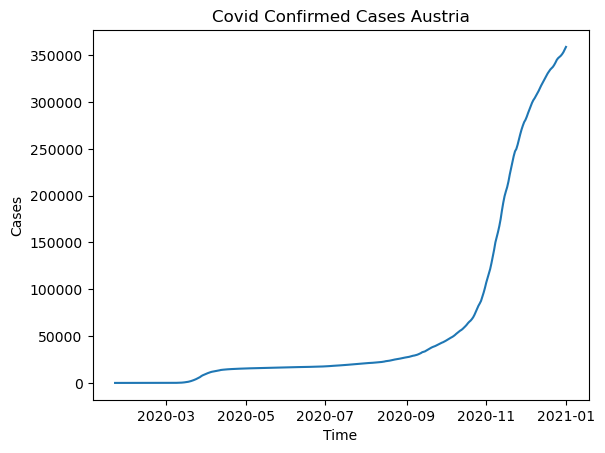

In [416]:
at_covid_df["Date"] = at_covid_df["Date"].apply(lambda d: pd.to_datetime(str(d)))
plt.plot(at_covid_df["Date"], at_covid_df['Cases'])
plt.title('Covid Confirmed Cases Austria')
plt.xlabel('Time')
plt.ylabel('Cases')

C:\Users\Dage Zhu\AppData\Local\Temp\ipykernel_15136\1179510072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_co_df["start"] = at_co_df["start"].apply(lambda d: pd.to_datetime(str(d)))


Text(0, 0.5, 'CO emission')

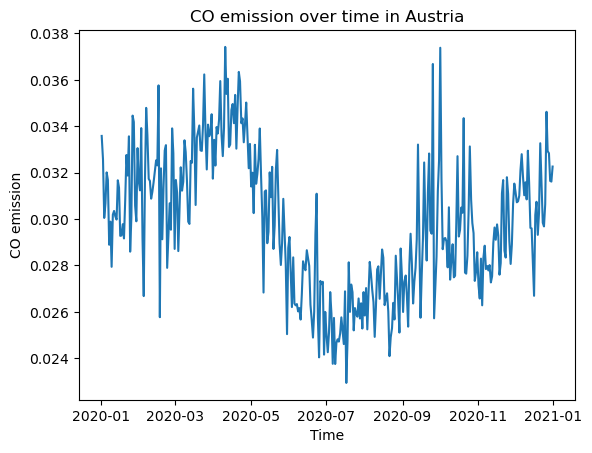

In [417]:
at_co_df["start"] = at_co_df["start"].apply(lambda d: pd.to_datetime(str(d)))
plt.plot(at_co_df["start"], at_co_df['average'])
plt.title('CO emission over time in Austria')
plt.xlabel('Time')
plt.ylabel('CO emission')

Anfangs, und aufgrund des frühen totalen Lockdowns in Österreich blieben die Infektionszahlen noch einigermaßen gering, doch kurz nach Schulbeginn beginnen die Zahlen wieder drastisch anzusteigen.

Das Erste was im CO Grafen auffällt ist, dass im Gegensatz zu den Covid-Infektionen der CO Graph um einiges instabiler ist. Dies kann mehrere Gründe haben, vor allem allerdings die schwankende Produktion durch wirtschaftliche Faktoren und die darauffolgende Produktionserhöhung bzw. Verringerung sind ausschlaggebend.

# Covid und Co Emissionen im 1.Lockdown

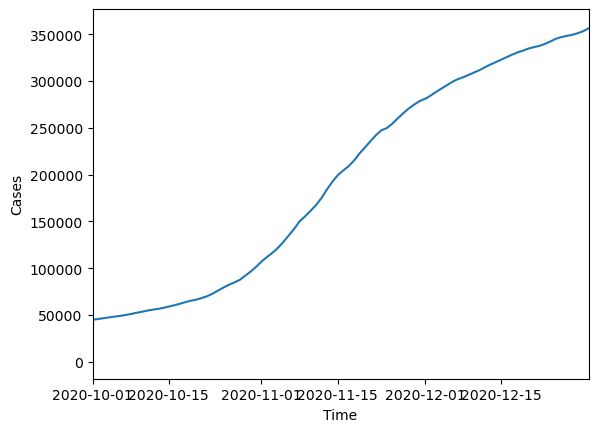

C:\Users\Dage Zhu\AppData\Local\Temp\ipykernel_15136\756711584.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_co_df['start'] = pd.to_datetime(at_co_df['start'], yearfirst = True)


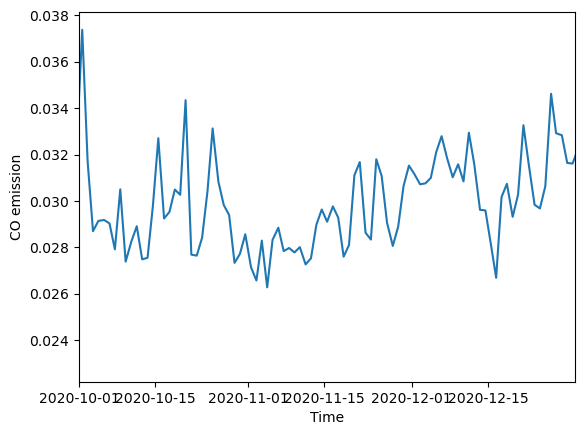

In [421]:
##fig.2 dann die lokalen extrema lesbar vl auch nur von 2020.11. an oder so
plt.plot(at_covid_df["Date"], at_covid_df['Cases'])
plt.xlabel('Time')
plt.ylabel('Cases')
plt.yticks()
ax = plt.gca()
ax.set_xlim([datetime.date(2020, 10, 1), datetime.date(2020, 12, 31)])
plt.show()

# at_co_df['start'] = [value.split('T', 1)[0] for value in at_co_df['start']]
at_co_df['start'] = pd.to_datetime(at_co_df['start'], yearfirst=True)
plt.plot(at_co_df['start'], at_co_df['average'])
plt.xlabel('Time')
plt.ylabel('CO emission')
plt.yticks()
ax = plt.gca()
ax.set_xlim([datetime.date(2020, 10, 1), datetime.date(2020, 12, 31)])
plt.show()

Während dem Lockdown lässt sich keine auffällig starke CO Emissions Verringerung in Österreich feststellen. Ein Hauptgrund könnte sein, dass Österreich mit rund 80 000 Industriebetrieben zwar zahlenmäßig weit vor Deutschland (mit rund 45.308 Industriebtrieben), doch umsatzmäßig mit 219 Milliarden Euro um einiges hinter Deutschland mit 1.893 Milliarden Euro liegt.

Österreich hat also mehr Kleinbetriebe, welche jedoch weniger produzieren, wodurch weniger Emissionen im gesamten in die Atmosphere gepumpt werden, fährt also ein Land mit weniger Emissionen den Betrieb soweit hinunter wie möglich, tut sich im gesamten weniger.

# Data Storage

## Docker Cassandra DB


In [238]:
!docker pull cassandra:latest
!docker network create cassandra
!docker run --rm -d --name bigdata_cassandra -p 9042:9042 --hostname cassandra --network cassandra cassandra

latest: Pulling from library/cassandra
Digest: sha256:8d3187f77bfa34340e72735d642df18bc6db6ac7e6545ab471f3bce3c10b5dad
Status: Image is up to date for cassandra:latest
docker.io/library/cassandra:latest


Error response from daemon: network with name cassandra already exists
docker: Error response from daemon: Conflict. The container name "/bigdata_cassandra" is already in use by container "08d2f57adba56083fd0ccca8e2f1763a22d2a18345f1f00c6ed5204232099bdb". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


latest: Pulling from library/cassandra
Digest: sha256:8d3187f77bfa34340e72735d642df18bc6db6ac7e6545ab471f3bce3c10b5dad
Status: Image is up to date for cassandra:latest
docker.io/library/cassandra:latest


Error response from daemon: network with name cassandra already exists
docker: Error response from daemon: Conflict. The container name "/bigdata_cassandra" is already in use by container "08d2f57adba56083fd0ccca8e2f1763a22d2a18345f1f00c6ed5204232099bdb". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [239]:
# connect to cassandra
cluster = Cluster(protocol_version=5)
session = cluster.connect()  # default keyspace

#### Create Keyspace

In [240]:
statement = "CREATE KEYSPACE IF NOT EXISTS lockdown WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : '1' };"
session.execute(statement)

#### Create Table

Create Auto Increment Helper

In [257]:
statement = "CREATE TABLE lockdown.ids (id_name varchar, next_id counter, PRIMARY KEY (id_name)) "
session.execute(statement)

In [251]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.covid (id int, created_at timestamp, cases int, country text, PRIMARY KEY (id, created_at)) WITH CLUSTERING ORDER BY (created_at ASC)"
session.execute(statement)

In [252]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.co (id int, start_time timestamp, end_time timestamp, avg_emission float, country text, PRIMARY KEY (id, start_time, end_time)) WITH CLUSTERING ORDER BY (start_time ASC)"
session.execute(statement)

#### Insert data

Create Auto Increment Key

In [260]:
session.execute("UPDATE lockdown.ids SET next_id = next_id + 1  WHERE id_name = 'covid_id'")
session.execute("UPDATE lockdown.ids SET next_id = next_id + 1  WHERE id_name = 'co_id'")

Insert Covid data

In [270]:
prepared_query = session.prepare('INSERT INTO lockdown.covid(id, created_at, cases, country) VALUES (?,?,?,?)')
for data in covid_data_json:
    get_id_statement = "SELECT next_id FROM lockdown.ids WHERE id_name = 'covid_id'"
    get_id = session.execute(get_id_statement).one()
    update_id = "UPDATE lockdown.ids SET next_id = next_id + 1 WHERE id_name='covid_id'"
    session.execute(update_id)
    session.execute(prepared_query, (
        get_id.next_id, datetime.strptime(data["Date"], '%Y-%m-%dT%H:%M:%SZ'), data["Cases"], data["Country"]))

In [276]:
prepared_query = session.prepare(
    'INSERT INTO lockdown.co(id, start_time, end_time, avg_emission, country) VALUES (?,?,?,?,?)')
for data in co_data_json:
    get_id_statement = "SELECT next_id FROM lockdown.ids WHERE id_name = 'co_id'"
    get_id = session.execute(get_id_statement).one()
    update_id = "UPDATE lockdown.ids SET next_id = next_id + 1 WHERE id_name='co_id'"
    data["start"] = data["start"][:19]
    data["end"] = data["end"][:19]
    session.execute(prepared_query,
                    (get_id.next_id, datetime.strptime(data["start"], '%Y-%m-%dT%H:%M:%S'),
                     datetime.strptime(data["end"], '%Y-%m-%dT%H:%M:%S'), float(data["average"]), data["Country"]))

Get data

In [277]:
def pandas_factory(colnames, rows):
    return spark.createDataFrame(rows, schema=colnames)


session.row_factory = pandas_factory
session.default_fetch_size = None

In [278]:
query = "SELECT created_at, cases, country FROM lockdown.covid"
rslt = session.execute(query, timeout=None)
covid_df = rslt._current_rows
# sort date
# covid_df.sort_values(by='created_at', inplace=True)

In [305]:
query = "SELECT start_time, avg_emission, country FROM lockdown.co"
rslt = session.execute(query, timeout=None)
co_df = rslt._current_rows
# sort date
# co_data.sort_values(by='start_time', inplace=True)

# Data Analytics

In [371]:
at_covid_df = covid_df.select("*").filter(covid_df.country == "Austria").sort("created_at")
at_covid_df.show(1)

+-------------------+-----+-------+
|         created_at|cases|country|
+-------------------+-----+-------+
|2020-01-22 00:00:00|    0|Austria|
+-------------------+-----+-------+
only showing top 1 row



In [326]:
d_covid_df = covid_df.select("*").filter(covid_df.country == "Germany").sort("created_at")

In [327]:
it_covid_df = covid_df.select("*").filter(covid_df.country == "Italy").sort("created_at")

In [328]:
europe_covid_df = covid_df.select("*").sort("created_at")

In [385]:
at_co_df = co_df.select("*").filter(co_df.country == "Austria").sort("start_time")
at_co_df.show(1)

+-------------------+--------------------+-------+
|         start_time|        avg_emission|country|
+-------------------+--------------------+-------+
|2020-01-01 10:32:22|0.033580683171749115|Austria|
+-------------------+--------------------+-------+
only showing top 1 row



In [330]:
d_co_df = co_df.select("*").filter(co_df.country == "Germany").sort("start_time")

In [331]:
it_co_df = co_df.select("*").filter(co_df.country == "Italy").sort("start_time")

In [332]:
europe_co_df = co_df.select("*").sort("start_time")

In [333]:
at_co_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
avg_emission,365,0.029776274081166475,0.003011503580639,0.02293492667376995,0.03741670772433281
country,365,None,None,Austria,Austria


In [348]:
at_covid_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
cases,346,63961.511560693645,99733.46651731672,0,358774
country,346,None,None,Austria,Austria


In [358]:
def get_date_df(name, days, start_day):
    initial_date = start_day
    one_day = datetime.timedelta(days=1)
    all_days = [{name: initial_date + i * one_day} for i in range(days)]
    return spark.createDataFrame(Row(**x) for x in all_days)


date_df = get_date_df("created_at", 22, start_day=datetime.date(2020, 1, 1))
date_df.show()

+----------+
|created_at|
+----------+
|2020-01-01|
|2020-01-02|
|2020-01-03|
|2020-01-04|
|2020-01-05|
|2020-01-06|
|2020-01-07|
|2020-01-08|
|2020-01-09|
|2020-01-10|
|2020-01-11|
|2020-01-12|
|2020-01-13|
|2020-01-14|
|2020-01-15|
|2020-01-16|
|2020-01-17|
|2020-01-18|
|2020-01-19|
|2020-01-20|
+----------+
only showing top 20 rows



In [374]:
dataCollect = date_df.collect()
for row in dataCollect:
    newRow = spark.createDataFrame([(row[0], 0, "Austria")], at_covid_df.columns)
    at_covid_df = at_covid_df.union(newRow)

In [377]:
at_covid_df = at_covid_df.distinct()

In [378]:
at_covid_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
cases,367,60301.58855585831,97966.06826355123,0,358774
country,367,None,None,Austria,Austria


In [396]:
at_co_df = at_co_df.withColumn("start_time", substring("start_time", 1, 10))
at_covid_df = at_covid_df.withColumn("created_at", substring("created_at", 1, 10))

In [397]:
at_covid_df.show(2)

+----------+------+-------+
|created_at| cases|country|
+----------+------+-------+
|2020-05-25| 16421|Austria|
|2020-11-09|155484|Austria|
+----------+------+-------+
only showing top 2 rows



In [398]:
at_df = at_co_df.join(at_covid_df, at_co_df.start_time == at_covid_df.created_at, "left")

In [399]:
at_df.show()

+----------+--------------------+-------+----------+-----+-------+
|start_time|        avg_emission|country|created_at|cases|country|
+----------+--------------------+-------+----------+-----+-------+
|2020-01-05| 0.03200783208012581|Austria|2020-01-05|    0|Austria|
|2020-01-03|0.030046286061406136|Austria|2020-01-03|    0|Austria|
|2020-01-12|0.030108971521258354|Austria|2020-01-12|    0|Austria|
|2020-01-01|0.033580683171749115|Austria|2020-01-01|    0|Austria|
|2020-01-06|0.031684279441833496|Austria|2020-01-06|    0|Austria|
|2020-01-16| 0.02927355468273163|Austria|2020-01-16|    0|Austria|
|2020-01-18|0.029774969443678856|Austria|2020-01-18|    0|Austria|
|2020-01-10|0.030185269191861153|Austria|2020-01-10|    0|Austria|
|2020-01-20| 0.03079894371330738|Austria|2020-01-20|    0|Austria|
|2020-01-11|0.030346501618623734|Austria|2020-01-11|    0|Austria|
|2020-01-19|0.029162049293518066|Austria|2020-01-19|    0|Austria|
|2020-01-17|0.029287073761224747|Austria|2020-01-17|    0|Aust

In [439]:
vectorAssembler = VectorAssembler(inputCols=['cases'], outputCol='features')
vat_df = vectorAssembler.transform(at_df)
vat_df = vat_df.select(['features', 'avg_emission'])
vat_df.show(3)

+--------+--------------------+
|features|        avg_emission|
+--------+--------------------+
|   [1.0]|0.029538461938500404|
|   [0.0]| 0.03200783208012581|
|   [0.0]|0.030046286061406136|
+--------+--------------------+
only showing top 3 rows



In [440]:
splits = vat_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [408]:
lr = LinearRegression(featuresCol='features', labelCol='avg_emission', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0]
Intercept: 0.029864517539348937


In [410]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.003003
r2: 0.000000


In [411]:
train_df.describe().show()

+-------+--------------------+
|summary|        avg_emission|
+-------+--------------------+
|  count|                 267|
|   mean| 0.02986451753934894|
| stddev|0.003008320270872787|
|    min| 0.02293492667376995|
|    max| 0.03741670772433281|
+-------+--------------------+



In [412]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "avg_emission", "features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="avg_emission", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+--------------------+--------------------+--------+
|          prediction|        avg_emission|features|
+--------------------+--------------------+--------+
|0.029864517539348937| 0.02576783113181591|   [0.0]|
|0.029864517539348937| 0.02667834609746933|   [0.0]|
|0.029864517539348937| 0.02913847379386425|   [0.0]|
|0.029864517539348937|0.029287073761224747|   [0.0]|
|0.029864517539348937|0.029774969443678856|   [0.0]|
+--------------------+--------------------+--------+
only showing top 5 rows

R Squared (R2) on test data = -0.0119461


In [475]:
# model = RandomForest.trainRegressor(train_df, {}, 3, seed=42)
# model.numTrees()
assembler = VectorAssembler(inputCols=['cases'], outputCol='features')
rf = RandomForestRegressor(labelCol="avg_emission", featuresCol="features")

In [476]:
pipeline = Pipeline(stages=[assembler, rf])

In [477]:
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [int(x) for x in np.linspace(start=10, stop=50, num=3)]).addGrid(
    rf.maxDepth, [int(x) for x in np.linspace(start=5, stop=25, num=3)]).build()

In [481]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="avg_emission", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

In [473]:
(trainingData, testData) = at_df.randomSplit([0.8, 0.2])

In [482]:
cvModel = crossval.fit(trainingData)

In [483]:
predictions = cvModel.transform(testData)

In [487]:
evaluator = RegressionEvaluator(labelCol="avg_emission", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(at_df)
rfResult = rfPred.toPandas()

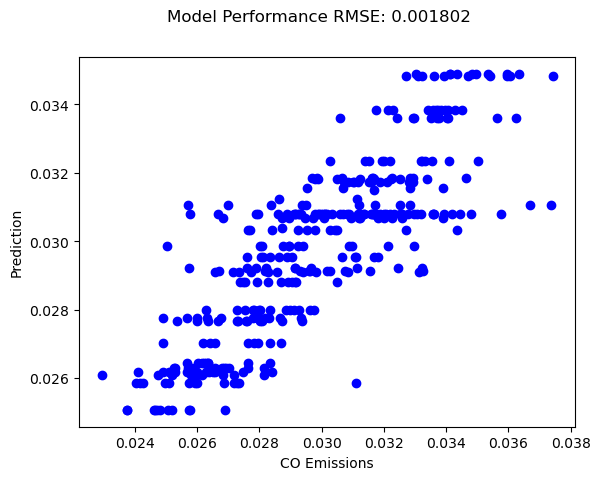

In [486]:
plt.plot(rfResult.avg_emission, rfResult.prediction, 'bo')
plt.xlabel('CO Emissions')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

# Data Presentation

# Covid und CO Emissionen Deutschland

Deutschland hat im Thema Corona zu beginn nicht ganz so schnell reagiert wie Österreich, jedoch auch nicht einen so hohen ausschlag gegen ende des Jahres.

# Covid und CO Emissionen Italien

Anfangs der Pandemie hat es vorallem Italien Europaweit als eine der ersten getroffen.


Für alle drei:

In [521]:
europe_covid_df_pd = europe_covid_df.toPandas()

In [528]:
three_countries = europe_covid_df_pd.loc[europe_covid_df_pd['country'].isin(["Austria","Germany","Italy"])]

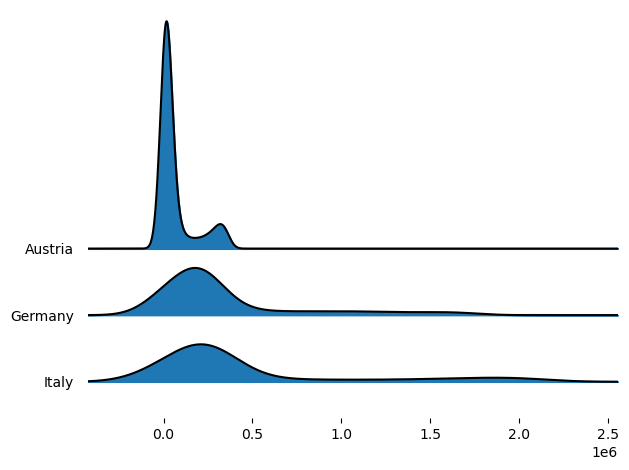

In [529]:
fig, axes = joypy.joyplot(three_countries, overlap=3, by="country")

# Covid und CO Emissionen Europaweit

<AxesSubplot:>

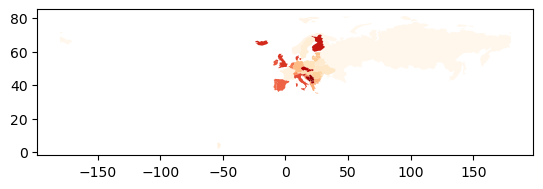

In [530]:
world = geo.read_file(geo.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

europe.plot(legend=True, cmap='OrRd')

In [531]:
# fig, axes = joypy.joyplot(covid_df, overlap=3)

TypeError: Unknown type for 'data': <class 'pyspark.sql.dataframe.DataFrame'>

In [ ]:
# sns.scatterplot(data=data, x="gdpPercap", sns.color_palette("crest", as_cmap=True), y="lifeExp", size="pop", legend=False, sizes=(20, 2000))
plt.show()

# Quellen

[1] https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich
[2] https://industriemagazin.at/artikel/alles-ueber-die-industrie-in-oesterreich/#:~:text=%C3%96sterreich%20hat%20mehrere%20wichtige%20Industriezweige,sowie%20die%20Holz%2D%20und%20Papierindustrie.
[3]https://www.deutschland.de/de/topic/wirtschaft/deutschlands-industrie-die-wichtigsten-zahlen-und-fakten